### Task 2
With any tooling you prefer, please build a model and conduct analysis into predicting loan defaulters based on the below data set of employment status, loan amount and bank balance


In [215]:
#load libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
# advanced scaling pipeline
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.linear_model import LogisticRegression #Classification
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report 

#### Data Importation and Exploratory Data Analysis
We will explore the dataset and note down all potential issues observed from the dataset and then clean/preprocess/transform

In [216]:
#Read the data
df = pd.read_csv("Default_Fin.csv", index_col = [0])

#preview
df.head()

,Employed,Bank Balance,Annual Salary,Defaulted?
Index,,,,
1,1,8754.36,532339.56,0
2,0,9806.16,145273.56,0
3,1,12882.60,381205.68,0
4,1,6351.00,428453.88,0
5,1,9427.92,461562.00,0


In [217]:
#data dimension
df.shape

(10000, 4)

In [218]:
#Check for missing values
df.isna().sum()

Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

There are no missing values in any of the columns. We can explore the unique values in each column and assign meaning/context to the data.

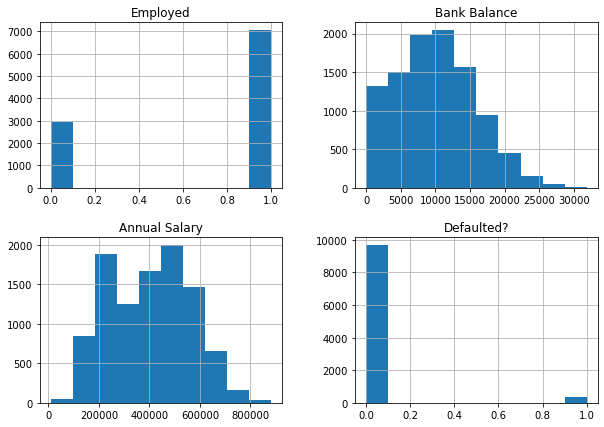

In [219]:
#Create a histogram of each column to examine data distribution
df.hist(figsize = (10, 7))
plt.show()

Column interpretation
0 = No (Not employed)
1 = Yes (Employed)


In [220]:
#Examine the employed column
df["Employed"].unique()

array([1, 0], dtype=int64)

### Some things to note on each column
1. Bank Balance - Appears to be skewed rightly with a few outliers.
2. Annual Salary - Appears to have a normal distribution
3. Defaulted? - There is clearly a case of class imbalance. 
4. Employed - is slightly unbalanced.

#### Multi Variate Analysis
We will cross the features and explore patterns and relationships

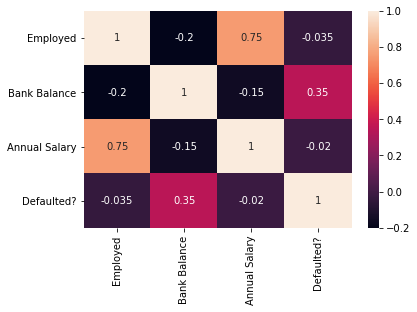

In [221]:
#Check for multicolinearity
sns.heatmap(df.corr(), annot = True)
plt.show()

<AxesSubplot:xlabel='Bank Balance', ylabel='Annual Salary'>

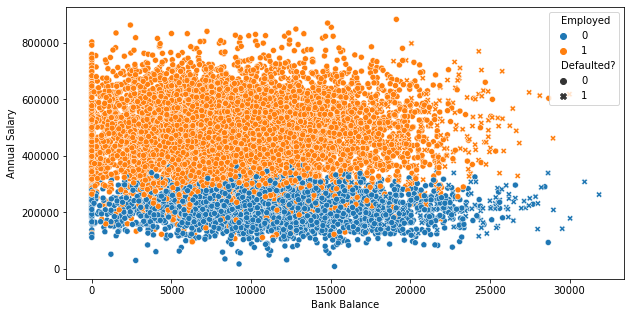

In [222]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = df,
                x = "Bank Balance",
                y = "Annual Salary", hue = "Employed",
               style = "Defaulted?")

### Class Imbalance

In [223]:
#Examine the % of defaulters to non defaulters
df["Defaulted?"].value_counts()/10000 * 100

0    96.67
1     3.33
Name: Defaulted?, dtype: float64

Distribution of groups on the defaulted column is at a ratio of 97% (Non-defaulters) ~ 3 (Defaulters).

In [224]:
#Examine the % of employed to un empployed
df["Employed"].value_counts()/10000 * 100

1    70.56
0    29.44
Name: Employed, dtype: float64

There is a 71% (employed = 1) ~ 29% (unemployed = 0)

#### Chi Square Test
We will perform a chi square test between the categorical variables (Employed, Defaulted) and see if they are related. 
* The null hypothesis (H0) is; there exist no relationship
* If alpha value is > 0.05, we accept the null, otherwise we reject( implying there is a relationship between both variables)

In [225]:
#Continge
from scipy.stats import chi2_contingency
  
# defining the table
data =  pd.crosstab(df['Employed'],
                            df['Defaulted?'], 
                               margins = False)
#data = [[207, 282, 241], [234, 242, 232]]
stat, p, dof, expected = chi2_contingency(data)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')


p value is 0.0004997256756210478
Dependent (reject H0)


## Data Transformation
Having Identified the issues with the dataset, we will:
**Normalize**
1. Normalize (to a normal or near normal distribution) the Bank Balance and as well scale
2. Scale the Annual Salary to ensure it's on the same scale as Bank Balance

**Oversample/Undersample**
1. The Defaulted? Column needs to be resampled. Using either SMOTE or dimensionality reduction approach (row reduction).
2. We will try out the same for Employed Column, but we will create a baseline model to examine the effects of each transformation on different experiments.


In [226]:
#Normalizing and Scaling the bank balance and Annual Salary
#make a copy
df_sklearn = df.copy()

df_sklearn.head()

,Employed,Bank Balance,Annual Salary,Defaulted?
Index,,,,
1,1,8754.36,532339.56,0
2,0,9806.16,145273.56,0
3,1,12882.60,381205.68,0
4,1,6351.00,428453.88,0
5,1,9427.92,461562.00,0


Split data and scale Train and test variables separately to prevent data leak

In [227]:
##Feature and target names
features = df_sklearn.columns[0:3]
target = df_sklearn.columns[-1]

#X and y values
X = df_sklearn[features].values
y = df_sklearn[target].values

#splot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

print("The dimension of X_train is {}".format(X_train.shape))
print("The dimension of X_test is {}".format(X_test.shape))

#Scale features separately to prevent data leak
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The dimension of X_train is (7000, 3)
The dimension of X_test is (3000, 3)


### Model Building
We will build a baseline model to sample the predict performance of the data

#### Experiment 1: Baseline Model

In [228]:
# copy the data
# fit a model to all features
#Create the LogReg
#STEP 1
RANDOM_STATE = 200 # seed to recreate results
model = LogisticRegression(random_state = RANDOM_STATE, solver = "liblinear") #solver = liblinear means the target var is binary

#STEP 2: Fit the model on our train dataset
model.fit(X_train, y_train) #Where X_train contains the features and y_train contains the target var

#STEP3: Test the Model performance: running a prediction
predictions = model.predict(X_test)

#STEP4:
actual = y_test


In [229]:
#confusion matrix
confusion_matrix(actual, predictions)

array([[2888,    7],
       [  73,   32]], dtype=int64)

In [230]:
#Accuracy:
accuracy_score(actual, predictions)

0.9733333333333334

In [231]:
#recall
recall_score(actual, predictions)

0.3047619047619048

In [232]:
#precision
precision_score(actual, predictions)

0.8205128205128205

In [233]:
#ROC Curve function
def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.2}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

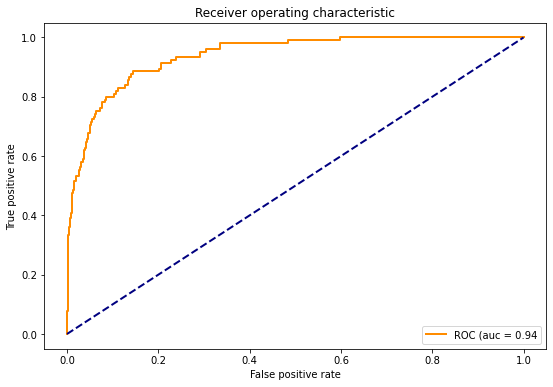

In [234]:
#Plot roc curve
#roc curve
y_score = model.predict_proba(X_test)[:,1]

#round probab values with python
np.round(y_score,1)

#roc curve
plot_roc_curve(actual, y_score)

### Experiment 2
#### Dealing with Class Imbalance
From the first model, recall is poor and below average. We will build a baseline model by undersampling the majority group.

In [235]:
#Get the number of each groups
class_0_maj_count, class_1_min_count = df_sklearn["Defaulted?"].value_counts()

#Separate the classes
class_0_maj = df_sklearn[df_sklearn["Defaulted?"] == 0]
class_1_min = df_sklearn[df_sklearn["Defaulted?"]== 1]

#resample using random undersampling of the majority class
class_0_rand = class_0_maj.sample(class_1_min_count, random_state = 10)

#Combine the new sample (class_0_rand) with the minority class (class_1_min)
df_rand = pd.concat([class_0_rand, class_1_min], axis = 0)

#preview
df_rand

,Employed,Bank Balance,Annual Salary,Defaulted?
Index,,,,
1182,1,9724.92,336681.36,0
2353,1,11919.60,342022.32,0
8250,0,6674.16,259809.96,0
5925,0,4503.72,232105.92,0
9485,0,9967.80,173047.44,0
...,...,...,...,...
9913,1,25786.80,531719.04,1
9922,0,19534.80,210564.00,1
9950,1,21003.00,618947.28,1


In [236]:
#Data size
df_rand["Defaulted?"].value_counts()

0    333
1    333
Name: Defaulted?, dtype: int64

In [237]:
#split data, scale and Build model
##Feature and target names
features = df_rand.columns[0:3]
target = df_rand.columns[-1]

#X and y values
X = df_rand[features].values
y = df_rand[target].values

#splot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

print("The dimension of X_train is {}".format(X_train.shape))
print("The dimension of X_test is {}".format(X_test.shape))

#Scale features separately to prevent data leak
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The dimension of X_train is (466, 3)
The dimension of X_test is (200, 3)


In [238]:
#Buildmodel
# copy the data
# fit a model to all features
#Create the LogReg
#STEP 1
RANDOM_STATE = 200 # seed to recreate results
model = LogisticRegression(random_state = RANDOM_STATE, solver = "liblinear") #solver = liblinear means the target var is binary

#STEP 2: Fit the model on our train dataset
model.fit(X_train, y_train) #Where X_train contains the features and y_train contains the target var

#STEP3: Test the Model performance: running a prediction
predictions = model.predict(X_test)

#STEP4:
actual = y_test


In [239]:
#confusion matrix
print("Confusion matrix",confusion_matrix(actual, predictions))

#Accuracy:
print("Accuracy score", accuracy_score(actual, predictions))

#recall
print("Recall Score", recall_score(actual, predictions))

#precision
print("Precision", precision_score(actual, predictions))

Confusion matrix [[80 10]
 [17 93]]
Accuracy score 0.865
Recall Score 0.8454545454545455
Precision 0.9029126213592233


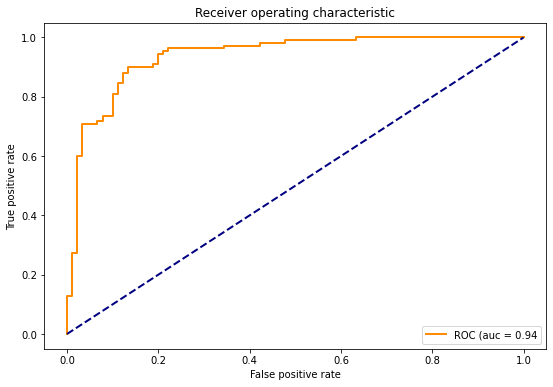

In [240]:
#Plot roc curve
#roc curve
y_score = model.predict_proba(X_test)[:,1]

#round probab values with python
np.round(y_score,1)

#roc curve
plot_roc_curve(actual, y_score)

#### Experiment 2 Results
This model appears to have a better performance as the recall, precision have improved. with almost 90% accuracy

### Experiment 3: Using a grid search model with Logistic Regression model

In [241]:
# use hyperparameter tuning combined with a scaling pipeline
scaler = StandardScaler() # scaling function

#same three lines below for grid search acroos hyperparameters C and penalty as in Method 3
param_grid = dict(C=[0.00001,0.0001,0.001,0.01,0.1,1,10],penalty=['l1','l2'])
regr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
cv = GridSearchCV(estimator=regr, param_grid=param_grid, scoring='average_precision')

pipeline = make_pipeline(scaler, cv) # here we SCALE the data so that all features are in the same "ballpark"

pipeline.fit(X_train, y_train) # fit the model to the SCALED data

y_true = y_test
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)[:, 1]

In [242]:
# a) extract model accuracy
accuracy_score(y_true, y_pred)

0.875

In [243]:
precision_score(y_true,y_pred)

0.8899082568807339

In [244]:
# b) display a confusion matrix
confusion_matrix(y_true,y_pred)

array([[78, 12],
       [13, 97]], dtype=int64)

In [245]:
recall_score(y_true,y_pred)

0.8818181818181818

#### Experiment 3 Results

Using a Grid search, the model does improve in accuracy compare to a experiment 2 by penalizing the model for overfitting. Improvement in recall but with a tradeoff in precision score.